In [1]:
import sys
sys.path.append('./scripts/')
from ideal_robot import *

In [4]:
class Robot(IdealRobot):
    pass

<IPython.core.display.Javascript object>


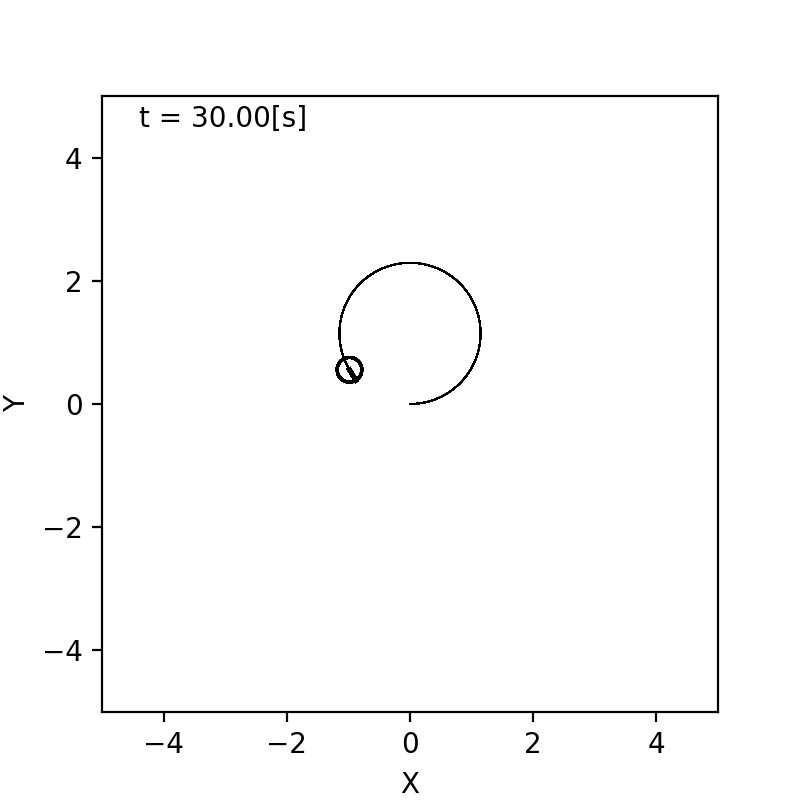

In [17]:
world = World(30, 0.1)

for i in range(100):
    circling=Agent(0.2, 10.0/180*math.pi)
    r = Robot(np.array([0,0,0]).T, sensor=None, agent=circling)
    world.append(r)
world.draw()

## 4.2 ロボットの移動に対する不確かさの要因の実装
#### 移動に関する雑音
1. 偶然誤差：継続期間が一瞬であるもの（小石への片輪の乗り上げ、走り出し、停止時のロボットの揺れ等）
2. 系統誤差：継続期間が数秒から数十秒であるもの(縁石への乗り上げ、走行環境の傾斜)
3. 1.2.の中間の誤差の原因:走行中ずっと継続するもの(左右の車輪にかかる荷重のバランスやモータの個体差、タイヤの状態)
4. 雑音と表現するには大きすぎるもの：走行不能になるレベルの障害物へのスタック、人間の干渉

次の４点をシミュレートしておけば自己位置推定や行動決定のアルゴリズムの評価が可能
* 雑音
* バイアス
* スタック
* 誘拐
### 4.2.1 移動に対して発生する雑音の実装
小石を踏んだ時の雑音にシミュレート。ロボットが次に小石を踏むまでの道のりは指数分布に従うものとする。
$$
    p(x|\lambda)=\lambda e^{\lambda x}
$$
$\lambda$は道のりあたりに踏みつける小石の数の期待値に相当。$\lambda^-1$は小石を一つ踏みつけるまでの道のりの期待値になる。

In [10]:
from scipy.stats import expon, norm

In [21]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black", 
                 noise_per_meter=5, noise_std=math.pi/60):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf=expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise=self.noise_pdf.rvs()
        self.theta_noise=norm(scale=noise_std)
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise-=abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise+=self.noise_pdf.rvs()
            pose[2]+=self.theta_noise.rvs()
        return pose
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs=self.sensor.data(self.pose) if self.sensor else None
        nu, omega=self.agent.decision(obs)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


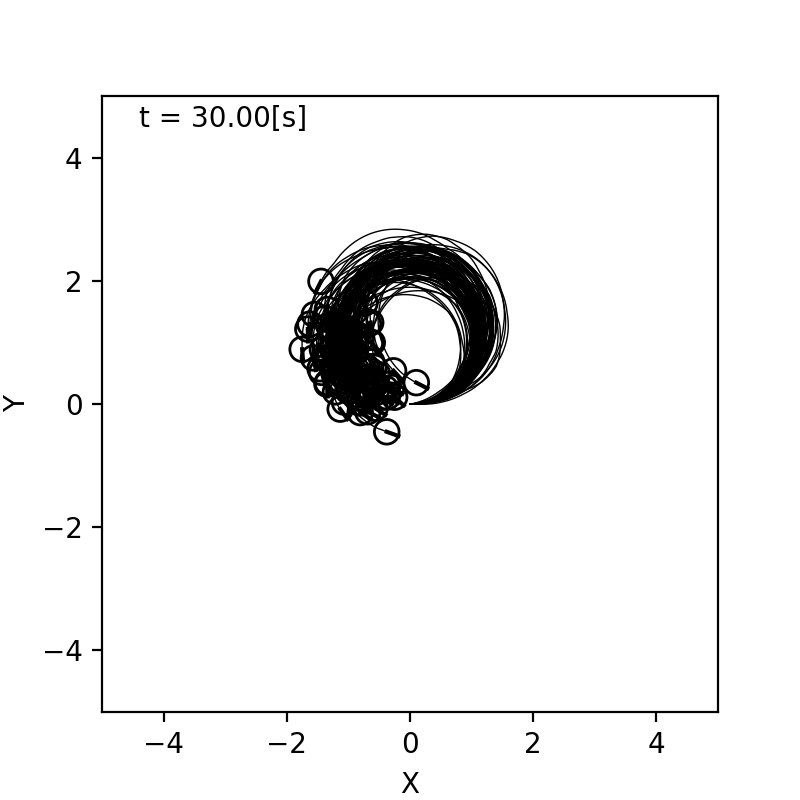

In [22]:
world = World(30, 0.1)

for i in range(100):
    circling=Agent(0.2, 10.0/180*math.pi)
    r = Robot(np.array([0,0,0]).T, sensor=None, agent=circling)
    world.append(r)
world.draw()

### 4.2.2 移動速度へのバイアスの実装
速度 $\nu$ と角速度 $\omega$ に一定の係数を掛け算をしてバイアスを発生させる。

In [23]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black", 
                 noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1, 0.1)):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf=expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise=self.noise_pdf.rvs()
        self.theta_noise=norm(scale=noise_std)
        self.bias_rate_nu=norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega=norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise-=abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise+=self.noise_pdf.rvs()
            pose[2]+=self.theta_noise.rvs()
        return pose
    
    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs=self.sensor.data(self.pose) if self.sensor else None
        nu, omega=self.agent.decision(obs)
        nu, omega=self.bias(nu, omega)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


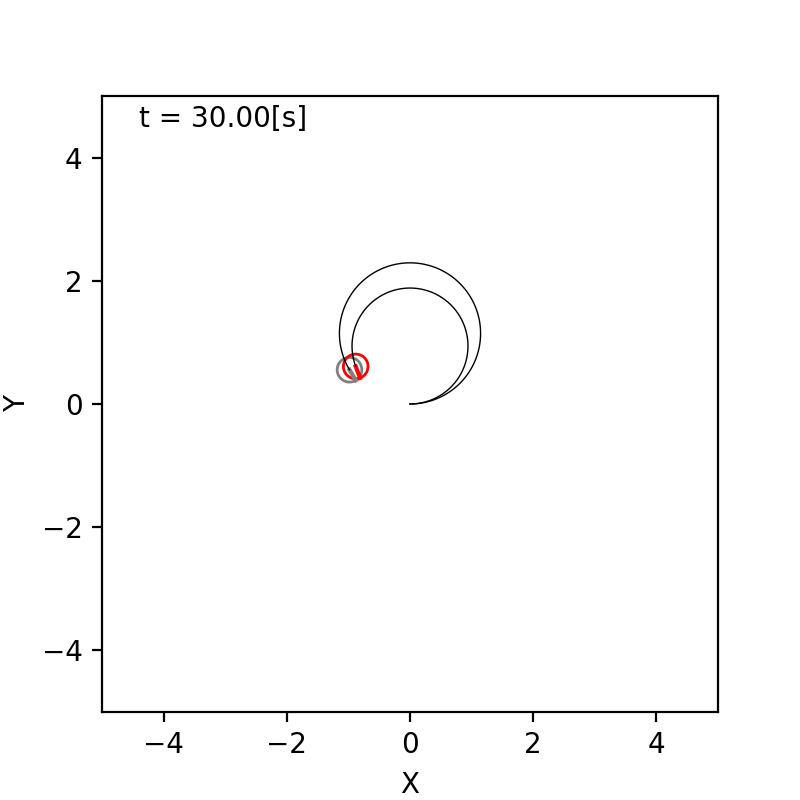

In [30]:
import copy

world = World(30, 0.1)

circling=Agent(0.2, 10.0/180*math.pi)
nobias_robot=IdealRobot(np.array([0,0,0]).T, sensor=None, agent=circling, color="gray")
world.append(nobias_robot)
biased_robot=Robot(np.array([0,0,0]).T, sensor=None, agent=circling, color="red", noise_per_meter=0, bias_rate_stds=(0.2, 0.2))
world.append(biased_robot)

world.draw()

### 4.2.3 スタックの実装

In [13]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black", 
                 noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1, 0.1), 
                expected_stuck_time=1e100, expected_escape_time=1e-100):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf=expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise=self.noise_pdf.rvs()
        self.theta_noise=norm(scale=noise_std)
        self.bias_rate_nu=norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega=norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        self.stuck_pdf=expon(scale=expected_stuck_time)
        self.escape_pdf=expon(scale=expected_escape_time)
        self.time_until_stuck=self.stuck_pdf.rvs()
        self.time_until_escape=self.escape_pdf.rvs()
        self.is_stuck=False
        
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape-=time_interval
            if self.time_until_escape <=0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck=False
        else:
            self.time_until_stuck-=time_interval
            if self.time_until_stuck <=0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck=True
                
        return nu*(not self.is_stuck), omega*(not self.is_stuck)
                
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise-=abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise+=self.noise_pdf.rvs()
            pose[2]+=self.theta_noise.rvs()
        return pose
    
    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs=self.sensor.data(self.pose) if self.sensor else None
        nu, omega=self.agent.decision(obs)
        nu, omega=self.bias(nu, omega)
        nu, omega=self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


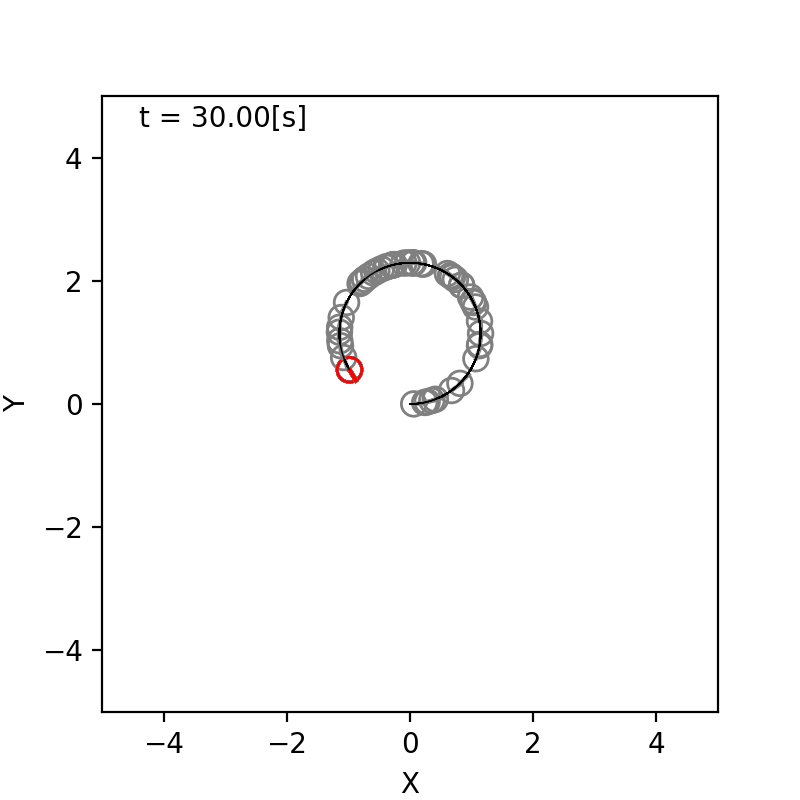

In [14]:
world=World(30, 0.1)
circling = Agent(0.2, 10.0/180*math.pi)

for i in range(100):
    r = Robot(np.array([0, 0, 0]).T, sensor=None, agent=circling, color="gray",
                      noise_per_meter=0, bias_rate_stds=(0.0,0.0),
             expected_stuck_time=60.0, expected_escape_time=60.0)
    world.append(r)
    
r = IdealRobot(np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red")
world.append(r)

world.draw()

### 4.2.4 誘拐の実装
誘拐後の姿勢は一様分布で選ぶ。
1次元の場合、次の確率密度関数で表される。

$$
p(x | a, b) = 
\begin{cases}
1 / (b-a) \quad ( a \leq x \leq b) \\
0 \quad (otherwise)
\end{cases}
$$

In [5]:
from scipy.stats import expon, norm, uniform
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black", 
                 noise_per_meter=5, noise_std=math.pi/60, bias_rate_stds=(0.1, 0.1), 
                expected_stuck_time=1e100, expected_escape_time=1e-100,
                expected_kidnap_time=1e100, kidnap_range_x=(-5.0, 5.0), kidnap_range_y=(-5.0, 5.0)):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf=expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise=self.noise_pdf.rvs()
        self.theta_noise=norm(scale=noise_std)
        self.bias_rate_nu=norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega=norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        self.stuck_pdf=expon(scale=expected_stuck_time)
        self.escape_pdf=expon(scale=expected_escape_time)
        self.time_until_stuck=self.stuck_pdf.rvs()
        self.time_until_escape=self.escape_pdf.rvs()
        self.is_stuck=False
        self.kidnap_pdf=expon(scale=expected_kidnap_time)
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale = (rx[1]-rx[0], ry[1]-ry[0], 2*math.pi))
        
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape-=time_interval
            if self.time_until_escape <=0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck=False
        else:
            self.time_until_stuck-=time_interval
            if self.time_until_stuck <=0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck=True
        return nu*(not self.is_stuck), omega*(not self.is_stuck)
                
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise-=abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise+=self.noise_pdf.rvs()
            pose[2]+=self.theta_noise.rvs()
        return pose
    
    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -=time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs=self.sensor.data(self.pose) if self.sensor else None
        nu, omega=self.agent.decision(obs)
        nu, omega=self.bias(nu, omega)
        nu, omega=self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval)

<IPython.core.display.Javascript object>


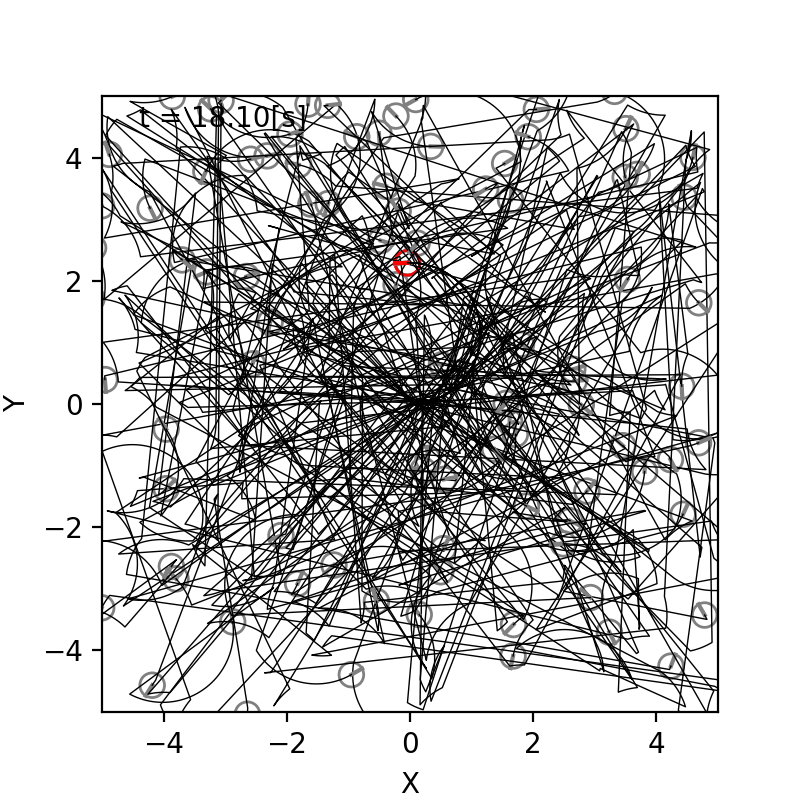

In [5]:
world=World(30, 0.1)
circling = Agent(0.2, 10.0/180*math.pi)

for i in range(100):
    r = Robot(np.array([0, 0, 0]).T, sensor=None, agent=circling, color="gray",
                      noise_per_meter=0, bias_rate_stds=(0.0,0.0),
             expected_kidnap_time=5)
    world.append(r)
    
r = IdealRobot(np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red")
world.append(r)

world.draw()

### 4.2.5 状態方程式と確率的な状態遷移モデル
ロボットの雑音やバイアスを状態方程式で扱う場合には一般に
$$
x_t = 
f(x_{t-1}, u_t) + \epsilon_t
$$
と表現される。ここで$\epsilon_t$は時刻 $ｔ$ の誤差を表している。
このような表現ではステップ毎に左辺の値が自動的に決定しているように見える。

そこで確率的な側面を表に出した状態方程式を考える。
状態遷移関数$f$に雑音をつけたものを以下の確率密度関数
$$
p(x|x_{t-1}, u_t)
$$
で置き換えると、状態方程式に相当する式は、
$$
x_t 〜  p(x|x_{t-1}, u_t)
$$
となる。
これは状態方程式というよりも確率遷移モデルという表現をされる。

## 4.3 ロボットの観測に対する不確かさの要因の実装
様々な誤差の原因をセンサ値に混ぜる。
誤差の種類として
* 偶然誤差
* 系統誤差
* 過失誤差：　実験時のデータ記入ミスetc

を与えると現実に起こることをよくシミュレーション可能。
以下の五種類の事象を実装する。

A) 雑音 : ガウス分布状のセンサ値のバラツキ \
B) バイアス : 常に距離方角に一定の値が加算 \
C) ファントム : 見えないランドマークの観測 \
D) 見落とし : 見えるはずのランドマークを見落とし \
E) オクルージョン : ランドマークの一部が物体に隠されて見えずにセンサ値に影響

### 4.3.1 センサ値に対する雑音の実装

In [12]:
class Camera(IdealCamera):
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90):
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise

<IPython.core.display.Javascript object>


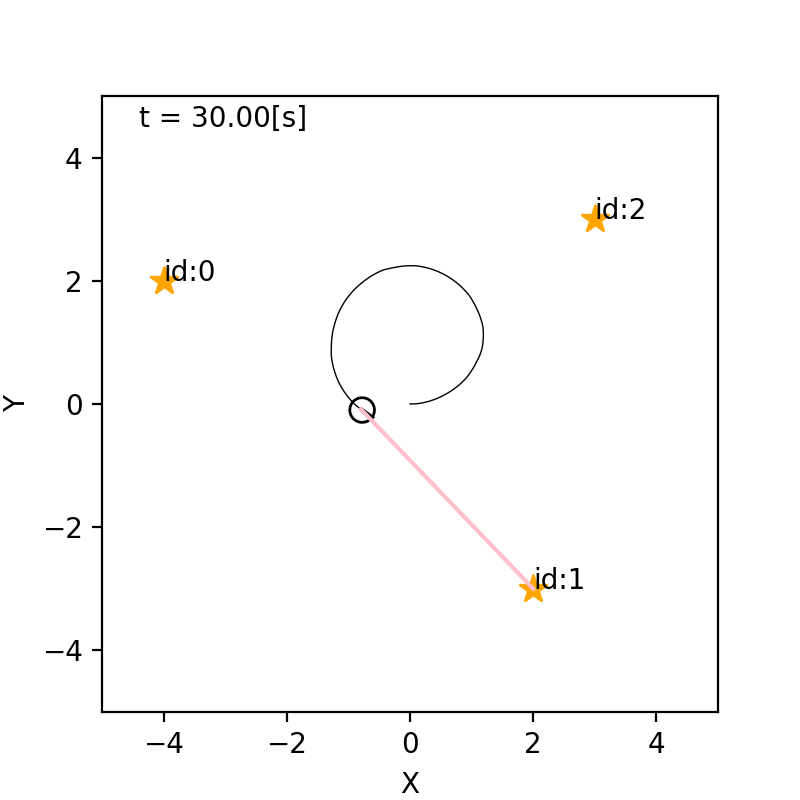

In [7]:
world = World(30, 0.1)

m = Map()
m.append_landmark(Landmark(-4, 2))
m.append_landmark(Landmark(2, -3))
m.append_landmark(Landmark(3, 3))
world.append(m)

circling = Agent(0.2, 10.0/180*math.pi)
r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling)
world.append(r)

world.draw()

In [42]:
class Camera(IdealCamera):
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90):
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise
        
    def noise(self, relpos):
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                z = self.noise(z)
                observed.append((z, lm.id))
                
        self.lastdata = observed
        return observed

<IPython.core.display.Javascript object>


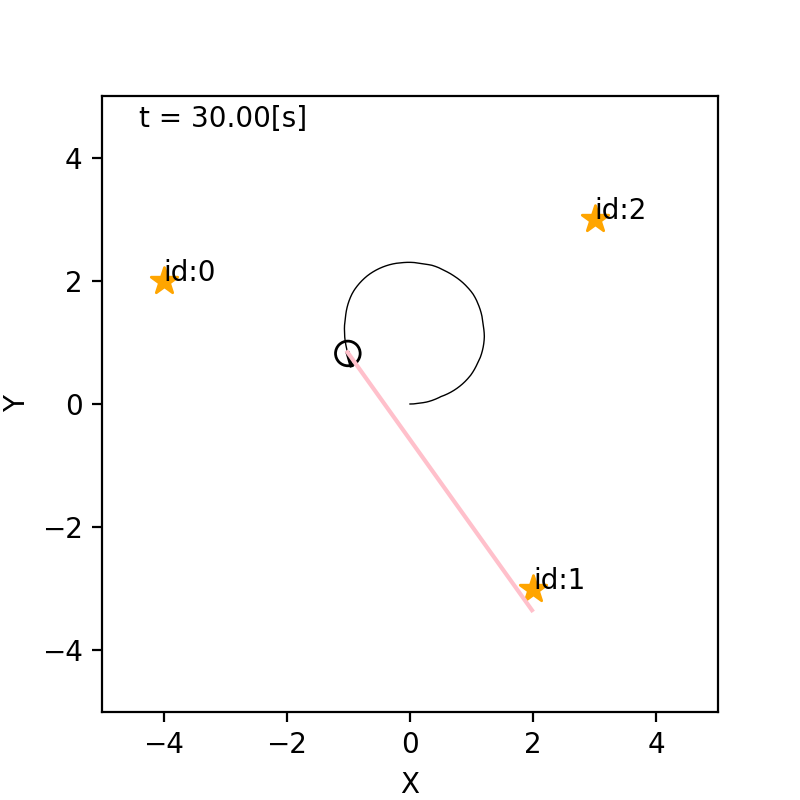

In [21]:
world = World(30, 0.1)

m = Map()
m.append_landmark(Landmark(-4, 2))
m.append_landmark(Landmark(2, -3))
m.append_landmark(Landmark(3, 3))
world.append(m)

circling = Agent(0.2, 10.0/180*math.pi)
r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling)
world.append(r)

world.draw()

### 4.3.2 センサ値に対するバイアスの実装

In [12]:
class Camera(IdealCamera):
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90):
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise
        self.distance_bias_rate_std = norm.rvs(scale = distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev)
        
    def noise(self, relpos):
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos):
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std, self.direction_bias]).T
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)
                observed.append((z, lm.id))
                
        self.lastdata = observed
        return observed

<IPython.core.display.Javascript object>


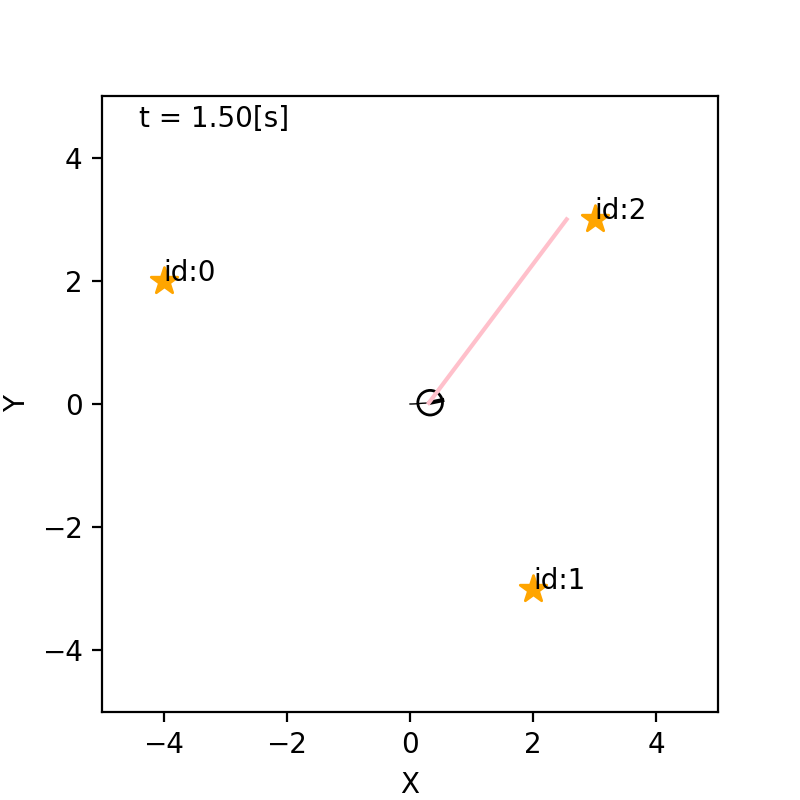

In [13]:
world = World(30, 0.1)

m = Map()
m.append_landmark(Landmark(-4, 2))
m.append_landmark(Landmark(2, -3))
m.append_landmark(Landmark(3, 3))
world.append(m)

circling = Agent(0.2, 10.0/180*math.pi)
r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling)
world.append(r)

world.draw()

### 4.3.3 ファントムの実装

In [52]:
class Camera(IdealCamera):
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0, 5.0), phantom_range_y=(-5.0, 5.0)):
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise
        self.distance_bias_rate_std = norm.rvs(scale = distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev)
        rx, ry = phantom_range_x, phantom_range_y
        self.pahtom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]- rx[0], ry[1]-ry[0]))
        self.phantom_prob=phantom_prob
        
    def noise(self, relpos):
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos):
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std, self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)
                observed.append((z, lm.id))
            z = self.phantom(cam_pose, z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)
                observed.append((z, lm.id))
                
        self.lastdata = observed
        return observed

./scripts/ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


<IPython.core.display.Javascript object>


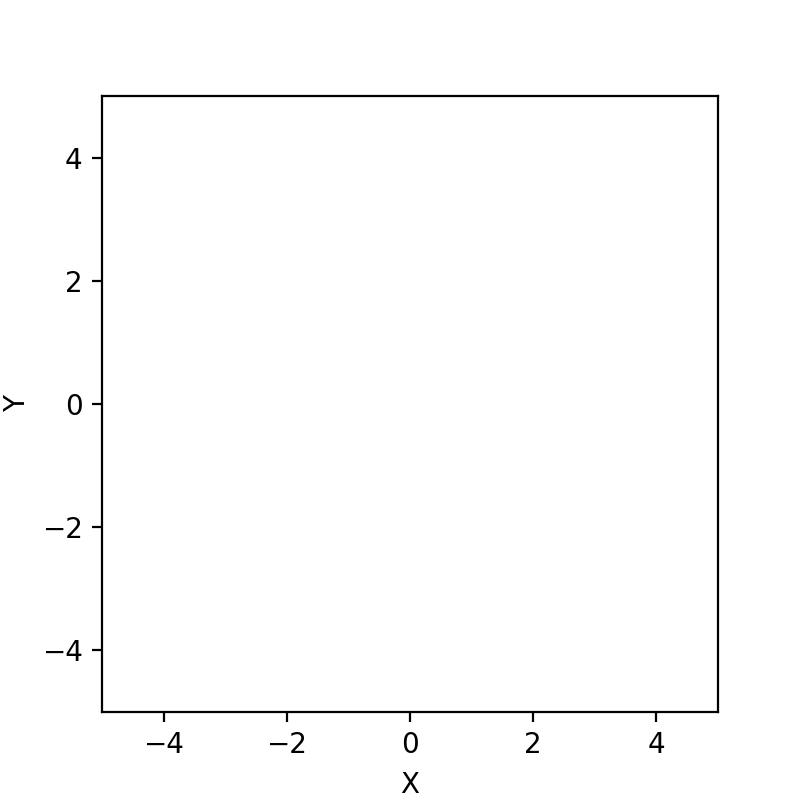

In [55]:
world = World(30, 0.1)

m = Map()
m.append_landmark(Landmark(-4, 2))
m.append_landmark(Landmark(2, -3))
m.append_landmark(Landmark(3, 3))
world.append(m)

circling = Agent(0.2, 10.0/180*math.pi)
r = Robot(np.array([0,0,0]).T, sensor=Camera(m, phantom_prob=0.3), agent=circling)
world.append(r)

world.draw()

### 4.3.4 見落としの実装

In [42]:
class Camera(IdealCamera):
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0, 5.0), phantom_range_y=(-5.0, 5.0),
                 oversight_prob=0.1):
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise
        self.distance_bias_rate_std = norm.rvs(scale = distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev)
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]- rx[0], ry[1]-ry[0]))
        self.phantom_prob=phantom_prob
        self.oversight_prob=oversight_prob
        
    def oversight(self, relpos):
        oversight = uniform.rvs()
        if oversight < self.oversight_prob:
            return None
        else:
            return relpos
        
    def noise(self, relpos):
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos):
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std, self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return pos
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z)
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)
                observed.append((z, lm.id))
                
        self.lastdata = observed
        return observed

<IPython.core.display.Javascript object>


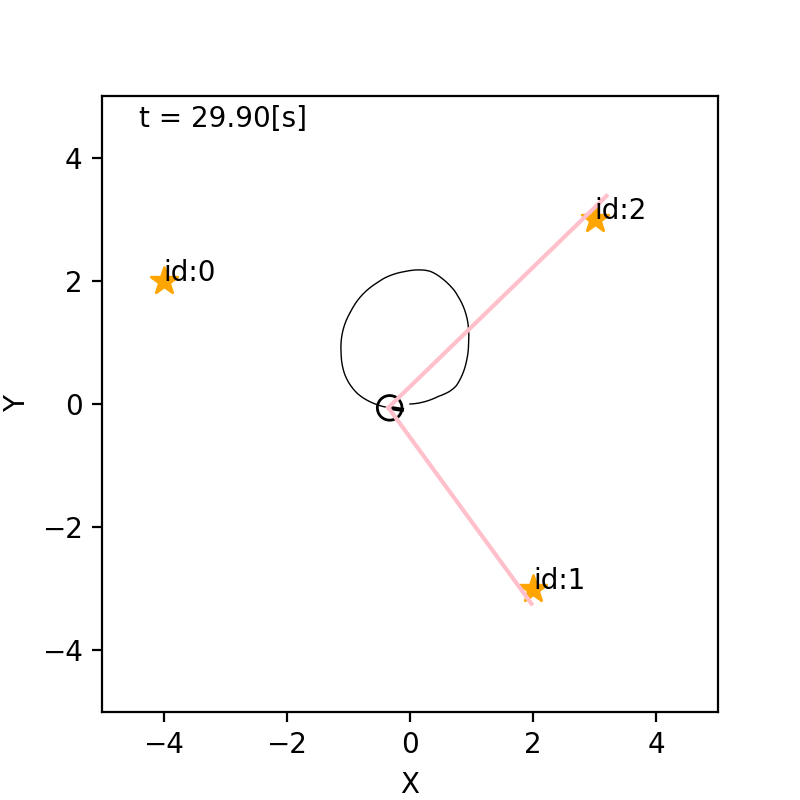

<IPython.core.display.Javascript object>


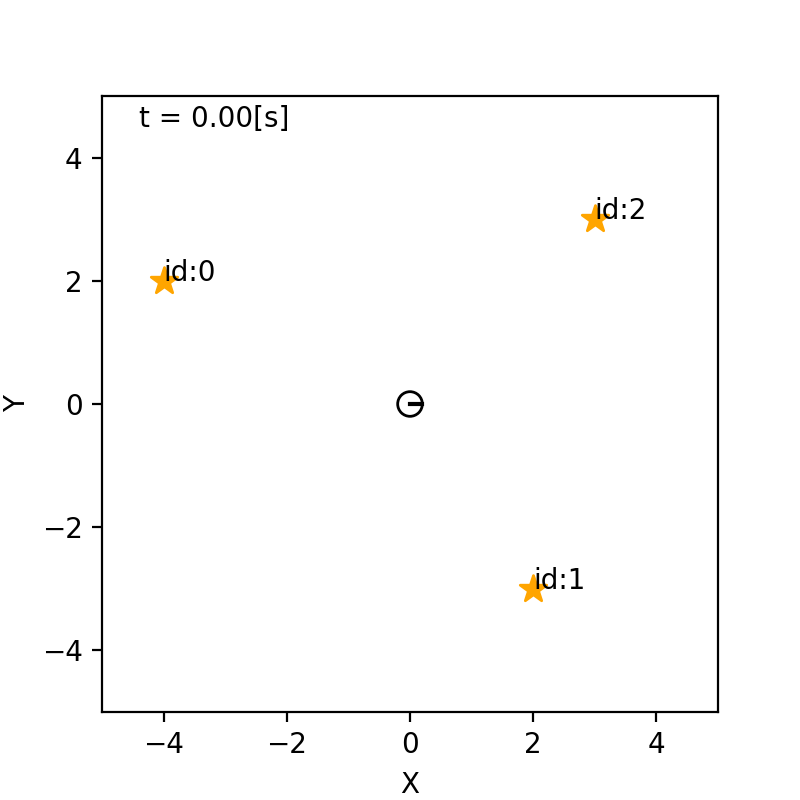

<IPython.core.display.Javascript object>


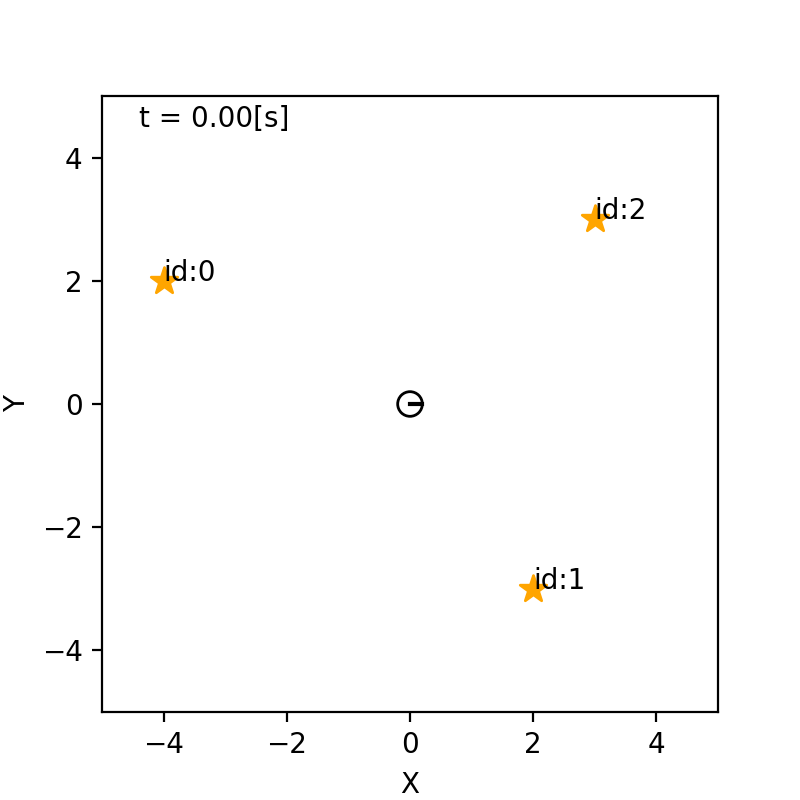

<IPython.core.display.Javascript object>


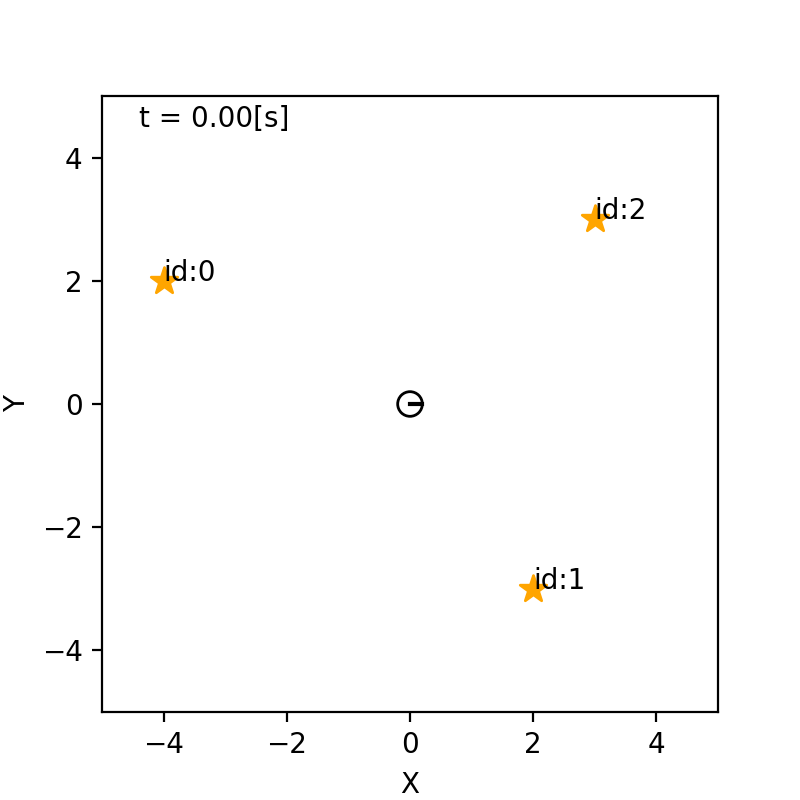

<IPython.core.display.Javascript object>


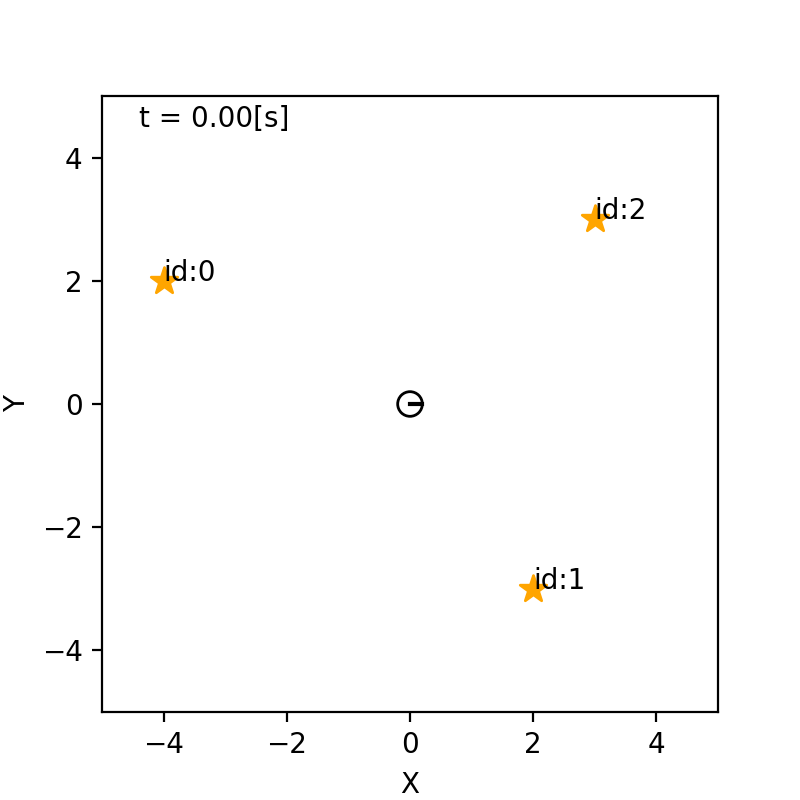

<IPython.core.display.Javascript object>


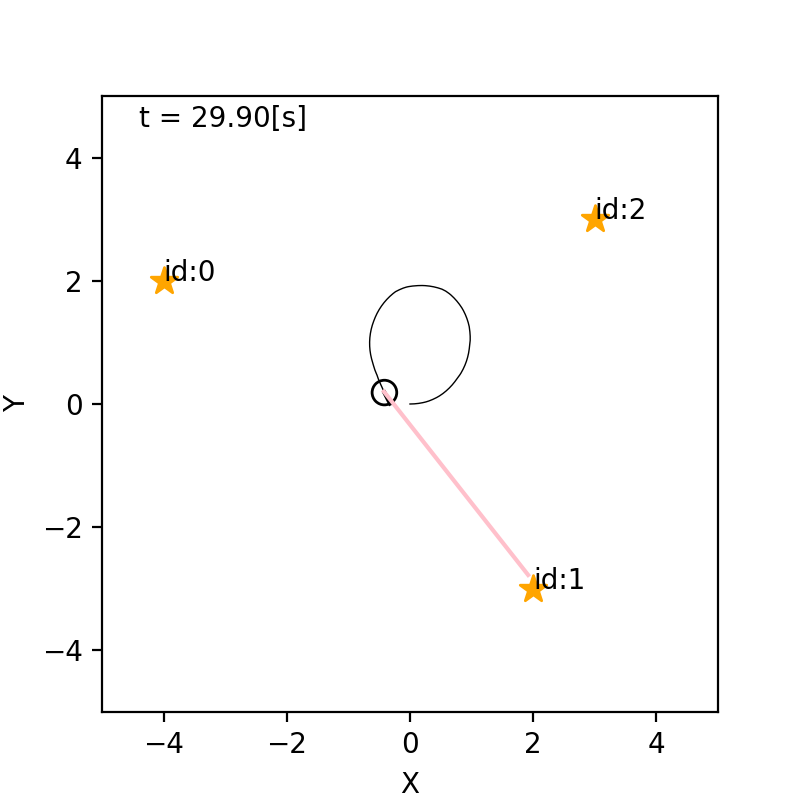

<IPython.core.display.Javascript object>


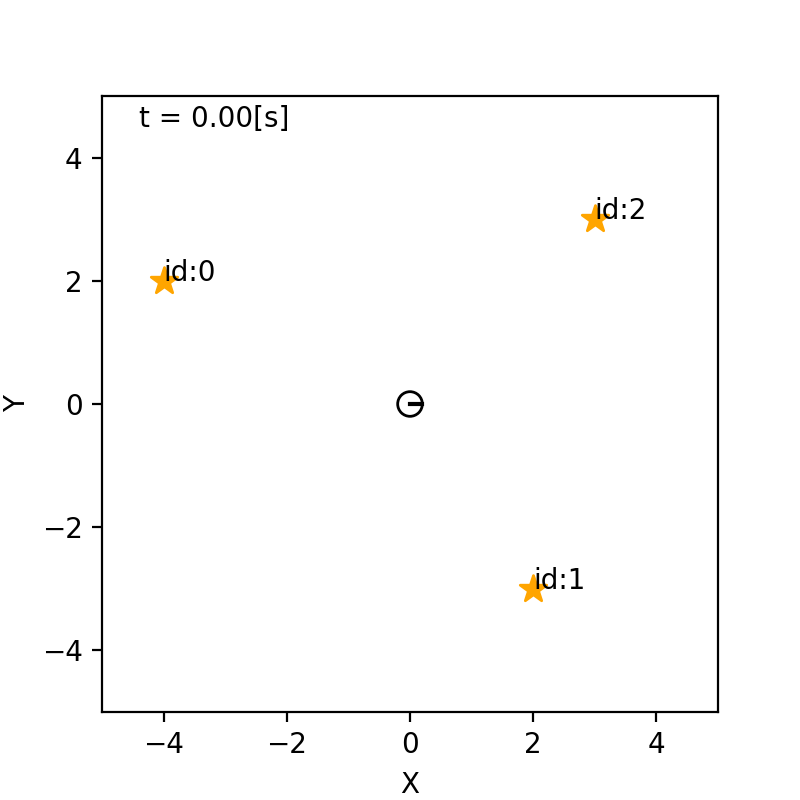

<IPython.core.display.Javascript object>


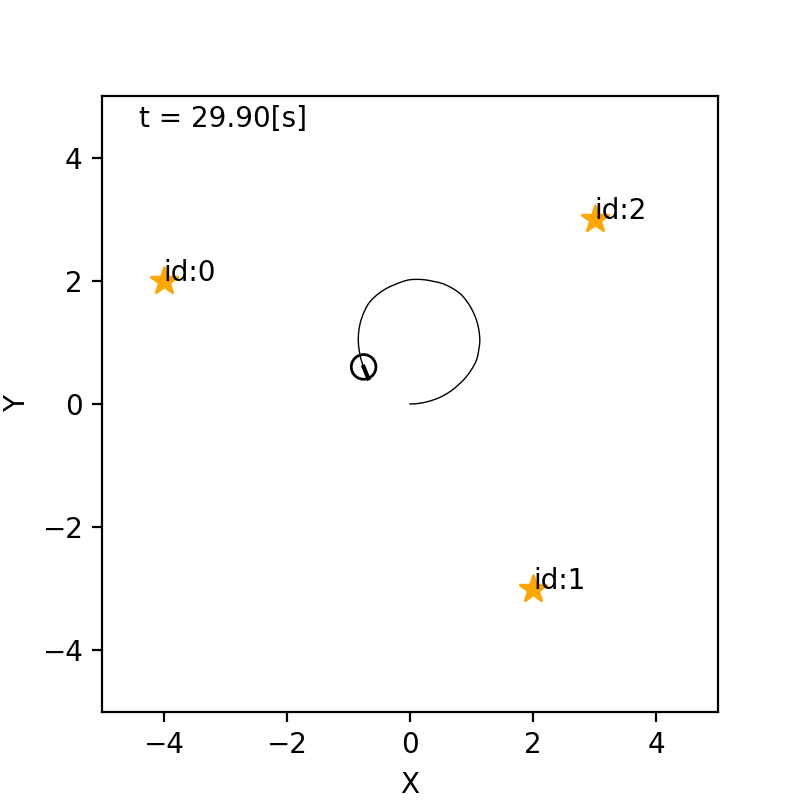

<IPython.core.display.Javascript object>


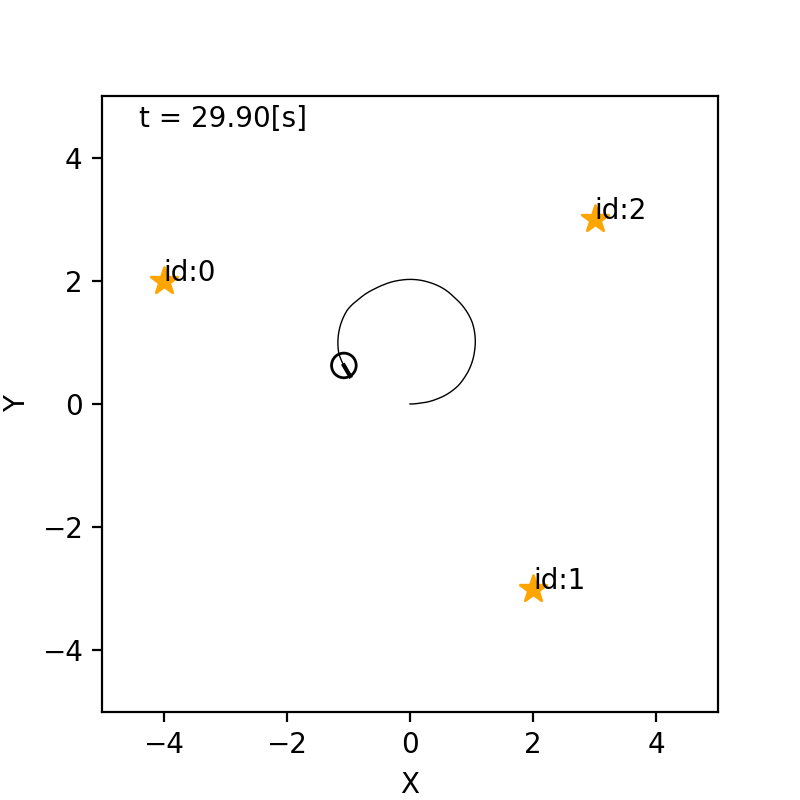

<IPython.core.display.Javascript object>


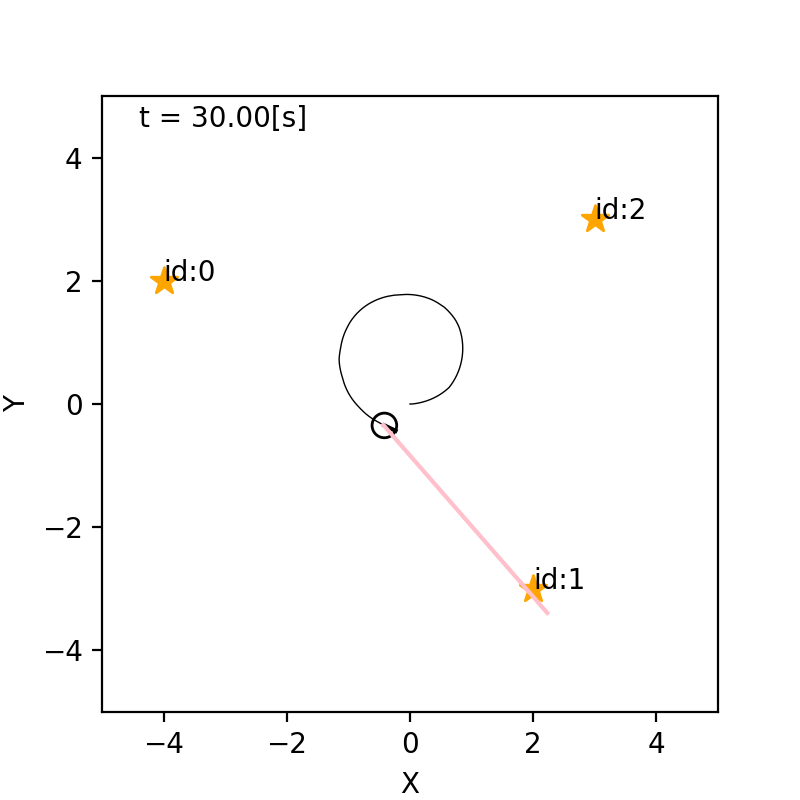

In [44]:
world = World(30, 0.1)

m = Map()
m.append_landmark(Landmark(-4, 2))
m.append_landmark(Landmark(2, -3))
m.append_landmark(Landmark(3, 3))
world.append(m)

circling = Agent(0.2, 10.0/180*math.pi)
r = Robot(np.array([0,0,0]).T, sensor=Camera(m, phantom_prob=0.3, oversight_prob=0.3), agent=circling)
world.append(r)

world.draw()

### 4.3.5 オクルージョンの実装

In [46]:
class Camera(IdealCamera):
    def __init__(self, env_map,
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3),
                 distance_noise_rate=0.1, direction_noise=math.pi/90,
                 distance_bias_rate_stddev=0.1, direction_bias_stddev=math.pi/90,
                 phantom_prob=0.0, phantom_range_x=(-5.0, 5.0), phantom_range_y=(-5.0, 5.0),
                 oversight_prob=0.1, occlusion_prob=0.0):
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise
        self.distance_bias_rate_std = norm.rvs(scale = distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev)
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]- rx[0], ry[1]-ry[0]))
        self.phantom_prob=phantom_prob
        self.oversight_prob=oversight_prob
        self.occlusion_prob=occlusion_prob
        
    def oversight(self, relpos):
        oversight = uniform.rvs()
        if oversight < self.oversight_prob:
            return None
        else:
            return relpos
        
    def noise(self, relpos):
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos):
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std, self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return pos
        else:
            return relpos
        
    def occlusion(self, relpos):
        if uniform.rvs() < self.occlusion_prob:
            ell = relpos[0]+uniform.rvs()*(self.distance_range[1] - relpos[0])
            phi = relpos[1]
            return np.array([ell, relpos[1]]).T
        else:
            return relpos
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z)
            z = self.occlusion(z)
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)
                observed.append((z, lm.id))
                
        self.lastdata = observed
        return observed

./scripts/ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


<IPython.core.display.Javascript object>


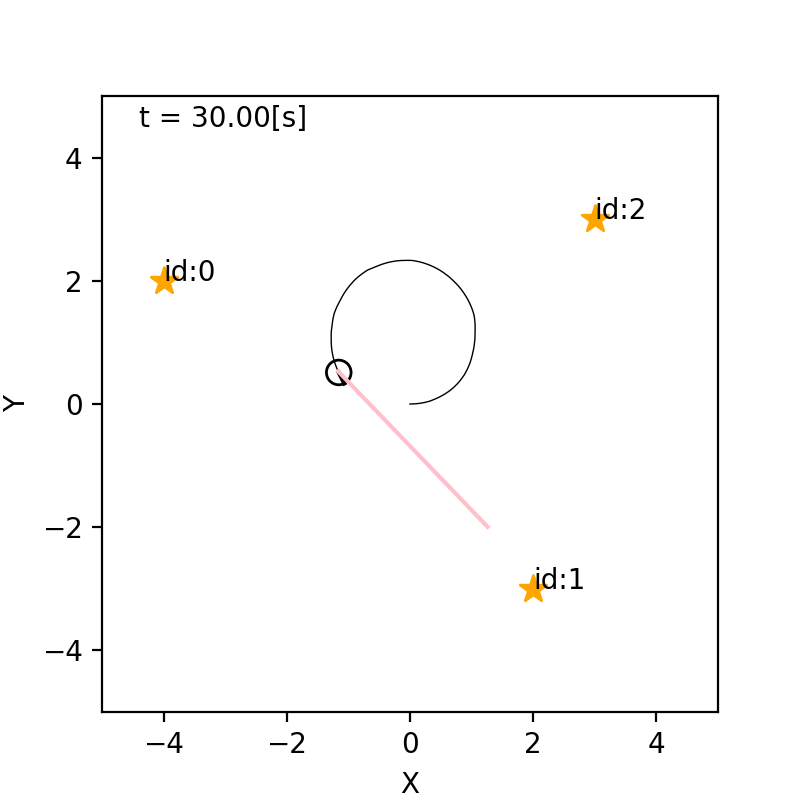

In [47]:
world = World(30, 0.1)

m = Map()
m.append_landmark(Landmark(-4, 2))
m.append_landmark(Landmark(2, -3))
m.append_landmark(Landmark(3, 3))
world.append(m)

circling = Agent(0.2, 10.0/180*math.pi)
r = Robot(np.array([0,0,0]).T, sensor=Camera(m, phantom_prob=0.3, oversight_prob=0.3, occlusion_prob=0.2), agent=circling)
world.append(r)

world.draw()

### 4.3.6 観測方程式と確率的な観測モデル
基本的に観測モデルは独立同分布(independent and identically distributed, iid)を前提としたものになる。
しかし、実際にはセンサ値のモデルは独立同分布でないことが多々ある。
ただ、以降のアルゴリズムは簡便なため、独立同分布であることを前提としたアルゴリズムになっている。